<a href="https://colab.research.google.com/github/fendiirfan/ML_forMarketing/blob/main/ML_for_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **2. Loading Libraries and data**

In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier

## **3. Understanding the data**

In [166]:
df = pd.read_csv('https://raw.githubusercontent.com/fendiirfan/ML_forMarketing/main/telco%20Dataset.csv')

In [167]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [168]:
type(df['TotalCharges'][0])

str

In [169]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [170]:
# check null data
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [171]:
a = [1,1,1]
a.index(1)

0

In [172]:
indexNullData = [488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754] # index dengan nilai kosong pada feature TotalCharges        
# drop null data
df = df.drop(indexNullData)
# reset index
df = df.reset_index()
df.drop(columns=['index'],inplace=True)

In [173]:
# cionvert data stype fetaure TotalCharger
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])


In [174]:
# Statistika deskriptif
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


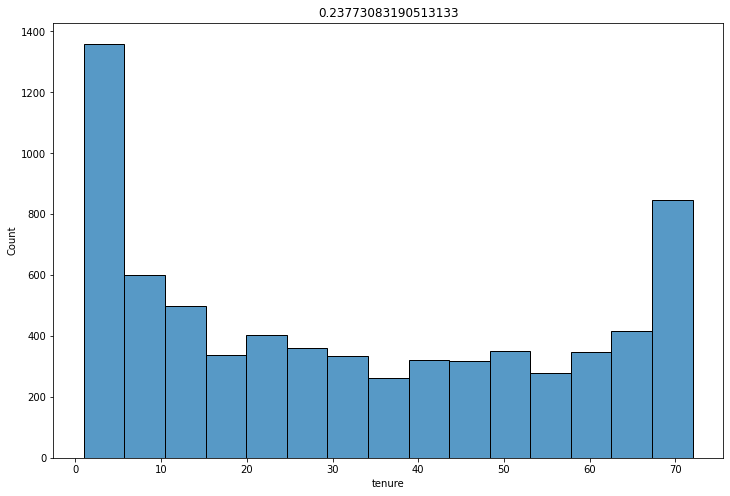

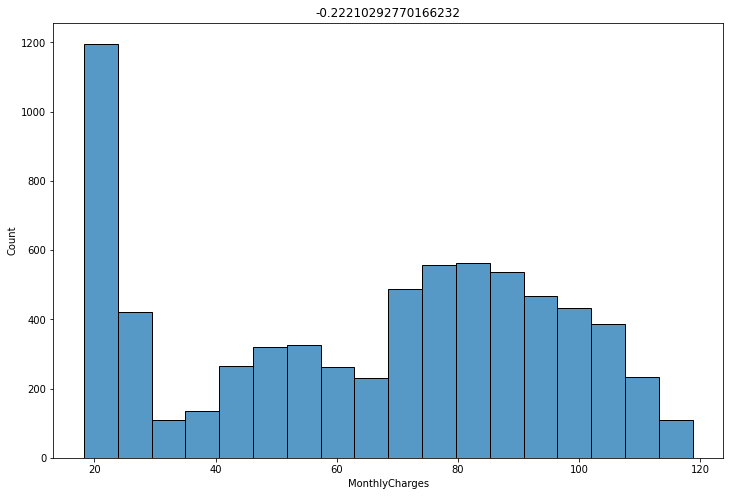

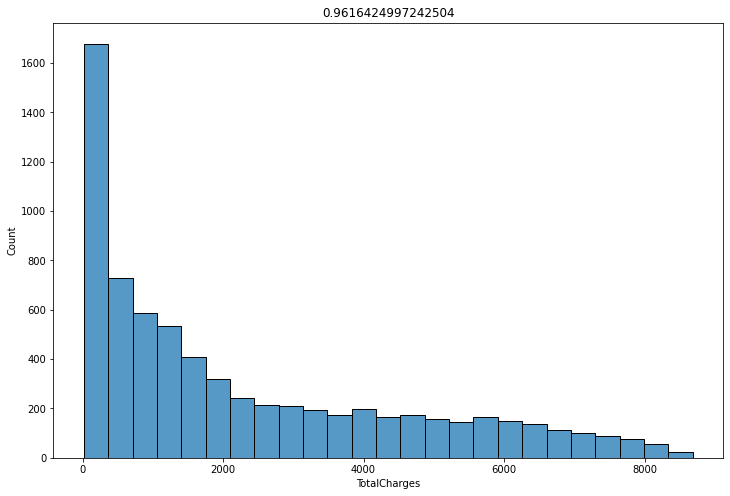

In [140]:
# cek sebaran data
for columnName in df.columns:
  if df[columnName].dtypes != 'object' and columnName!= 'SeniorCitizen':
    plt.figure(figsize=(12,8))
    plt.title(df[columnName].skew())
    sns.histplot(data=df, x=columnName)
    plt.show()

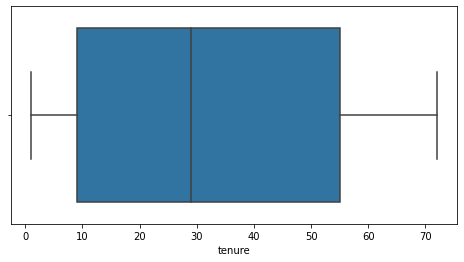

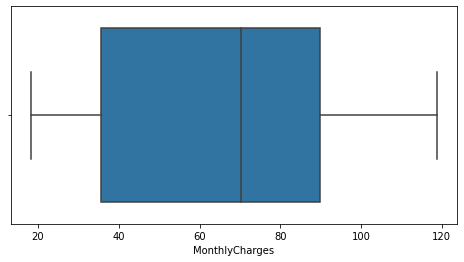

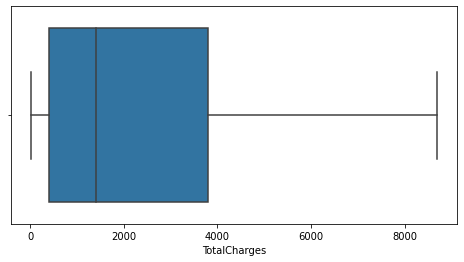

In [141]:
# check outliers
for columnName in df.columns:
  if df[columnName].dtypes != 'object' and columnName!= 'SeniorCitizen':
    plt.figure(figsize=(8,4))
    sns.boxplot(data=df, x=columnName)
    plt.show()

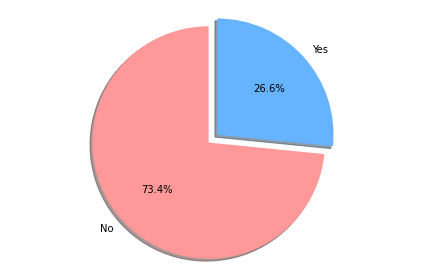

In [142]:
# melihat imbalance atau tidak dari data

# Pie chart
labels = [df['Churn'].unique()[0],df['Churn'].unique()[1]]
sizes = [df['Churn'].value_counts()[0],df['Churn'].value_counts()[1]]
# only "explode" the 2nd slice (i.e. 'Hogs')
explode = (0, 0.1)
#add colors
colors = ['#ff9999','#66b3ff']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')
plt.tight_layout()
plt.show()

## **Preprocessing**

In [143]:
custid = ['customerID']
target = ['Churn']

In [144]:
categorical = [col for col in df.columns
             if (df[col].dtypes=='object' and col not in custid+target)]
numerical = [col for col in df.columns
             if col not in custid+target+categorical]

One-hot encoding categorical variables

In [145]:
telco_raw = pd.get_dummies(data=df, columns=categorical, drop_first=True)

Scaling numerical features
bold text

In [146]:
# Import StandardScaler library
from sklearn.preprocessing import MinMaxScaler
# Initialize StandardScaler instance
scaler = MinMaxScaler()
# Fit the scaler to numerical columns
scaled_numerical = scaler.fit_transform(telco_raw[numerical])
# Build a DataFrame
scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical)

In [147]:
scaled_numerical.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
0,0.0,0.000000,0.115423,0.001275
1,0.0,0.464789,0.385075,0.215867
2,0.0,0.014085,0.354229,0.010310
3,0.0,0.619718,0.239303,0.210241
4,0.0,0.014085,0.521891,0.015330


In [148]:
# gabungkan jadi satu dataframe
telco_raw.drop(columns=numerical,inplace=True)
# merge
telco = telco_raw.merge(right=scaled_numerical,
                        how='left',
                        left_index=True,
                        right_index=True
                        )

In [149]:
# change churn yes=1 and no=0
telco['Churn'] = telco['Churn'].replace(['Yes','No'],
                                        [1,0])

## **XGBoost Model**

In [150]:
# 1. Split data to training and testing
train_X, test_X, train_Y, test_Y = train_test_split(telco.drop(columns=['Churn','customerID']),
                                                    telco['Churn'],
                                                    test_size=0.25,
                                                    random_state=2)

Supervised Learning

In [151]:
# XGBoost Classifier
model = XGBClassifier()
# fit model
model.fit(train_X,train_Y)
# predict model
predict = model.predict(test_X)
# check accuarcy
classification_report(test_Y,predict)

'              precision    recall  f1-score   support\n\n           0       0.84      0.89      0.87      1293\n           1       0.65      0.54      0.59       465\n\n    accuracy                           0.80      1758\n   macro avg       0.74      0.72      0.73      1758\nweighted avg       0.79      0.80      0.79      1758\n'

In [152]:
# Random Forest Classifier
treeModel = DecisionTreeClassifier()
# fit model
treeModel.fit(train_X,train_Y)
# predict model
predict = treeModel.predict(test_X)
# check accuarcy
classification_report(test_Y,predict)

'              precision    recall  f1-score   support\n\n           0       0.82      0.79      0.81      1293\n           1       0.47      0.50      0.48       465\n\n    accuracy                           0.72      1758\n   macro avg       0.64      0.65      0.65      1758\nweighted avg       0.72      0.72      0.72      1758\n'

In [153]:
# Feature Importance Uisng Tree Model
data = {
    'Name Column':train_X.columns,
    'Importance':treeModel.feature_importances_
}
importanceFeature = pd.DataFrame(data=data)
importanceFeature

,Name Column,Importance
0,gender_Male,0.024836
1,Partner_Yes,0.013540
2,Dependents_Yes,0.014960
3,PhoneService_Yes,0.003338
4,MultipleLines_No phone service,0.001326
5,MultipleLines_Yes,0.015895
6,InternetService_Fiber optic,0.111809
7,InternetService_No,0.004250
8,OnlineSecurity_No internet service,0.000000
9,OnlineSecurity_Yes,0.013020


In [154]:
from sklearn import tree
import graphviz
exported = tree.export_graphviz(decision_tree=treeModel,
                                        out_file=None,
                                        feature_names=train_X.columns,
                                        precision=1,
                                        class_names=['Not churn','Churn'],
                                        filled = True)
graph = graphviz.Source(exported)
display(graph)

Unsupervised Learning

In [155]:
data = telco.drop(columns=['Churn','customerID'])
# Initialize the model
kmeans = KMeans(n_clusters=3)
# Fit the model
kmeans.fit(data)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [156]:
# 3. Asign cluster values
data['Cluster'] = kmeans.labels_

**Explore results**

In [157]:
data.groupby(['Cluster']).mean()

,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.499393,0.722380,0.384864,0.911372,0.088628,0.660057,0.583165,0.0,0.0,0.556050,0.0,0.682315,0.0,0.728045,0.0,0.590854,0.0,0.738567,0.0,0.740996,0.333064,0.403885,0.667341,0.325779,0.267908,0.093889,0.184541,0.726404,0.700479,0.538484
1,0.506741,0.287734,0.168037,0.848405,0.151595,0.327524,0.544229,0.0,0.0,0.210786,0.0,0.243012,0.0,0.203551,0.0,0.190727,0.0,0.288721,0.0,0.295955,0.094048,0.017757,0.682012,0.126603,0.519895,0.209471,0.208484,0.224268,0.487786,0.129414
2,0.509211,0.482237,0.419079,1.000000,0.000000,0.223684,0.000000,1.0,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,1.0,0.000000,0.238816,0.416447,0.292763,0.217763,0.080263,0.483553,0.034211,0.417856,0.028122,0.074593


# customer lifetime value (clv) 

What is CLV?

Measurement of customer value

Can be historical or predicted

Multiple approaches, depends on business type

Some methods are formula-based, some are predictive and distribution based